<a href="https://colab.research.google.com/github/nkasmanoff/nasa_harvest_challenge/blob/main/Ensemble_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook covers the combining of separate models to now be used for submission to the challenge. 

Given 13 tiles, each with images taken at 6 different periods, the goal now is to return a csv file with two columns, the first indicating the image-pixel position, and then the predicted class, i.e. whether or not this a boundary or not. 

Using the combined models, along with the combined satellite images taken over these same areas, we can produce an output that is ready for submitting.

In [ ]:
# create the dataset
from google.colab import drive
drive.mount('/content/drive')

IMAGE_PATH = "/content/drive/MyDrive/data"


Mounted at /content/drive


In [ ]:
%pip install -qq -U rasterio diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.8 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import torch
import torchvision
from torch import nn
import numpy as np
import random 
from tqdm import tqdm
import os
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset
from torchvision import transforms
import scipy
import torch.nn.functional as F
from torch.nn import init

from skimage import filters
import pandas as pd
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:


class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x




class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

        



class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,capacity_factor=1, expanded_bottleneck = True):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64*capacity_factor)
        self.Conv2 = conv_block(ch_in=64*capacity_factor,ch_out=128*capacity_factor)
        self.Conv3 = conv_block(ch_in=128*capacity_factor,ch_out=256*capacity_factor)
        self.Conv4 = conv_block(ch_in=256*capacity_factor,ch_out=512*capacity_factor)
        self.Conv5 = conv_block(ch_in=512*capacity_factor,ch_out=1024*capacity_factor)
        self.expanded_bottleneck = expanded_bottleneck
        if self.expanded_bottleneck:
          self.ConvBottleneck = conv_block(ch_in=1024*capacity_factor,ch_out=1024*capacity_factor)

        self.Dropout = nn.Dropout2d(p=0.5)
        self.Up5 = up_conv(ch_in=1024*capacity_factor,ch_out=512*capacity_factor)
        self.Att5 = Attention_block(F_g=512*capacity_factor,F_l=512*capacity_factor,F_int=256*capacity_factor)
        self.Up_conv5 = conv_block(ch_in=1024*capacity_factor, ch_out=512*capacity_factor)

        self.Up4 = up_conv(ch_in=512*capacity_factor,ch_out=256*capacity_factor)
        self.Att4 = Attention_block(F_g=256*capacity_factor,F_l=256*capacity_factor,F_int=128*capacity_factor)
        self.Up_conv4 = conv_block(ch_in=512*capacity_factor, ch_out=256*capacity_factor)
        
        self.Up3 = up_conv(ch_in=256*capacity_factor,ch_out=128*capacity_factor)
        self.Att3 = Attention_block(F_g=128*capacity_factor,F_l=128*capacity_factor,F_int=64*capacity_factor)
        self.Up_conv3 = conv_block(ch_in=256*capacity_factor, ch_out=128*capacity_factor)
        
        self.Up2 = up_conv(ch_in=128*capacity_factor,ch_out=64*capacity_factor)
        self.Att2 = Attention_block(F_g=64*capacity_factor,F_l=64*capacity_factor,F_int=32*capacity_factor)
        self.Up_conv2 = conv_block(ch_in=128*capacity_factor, ch_out=64*capacity_factor)

        self.Final_Conv_Block = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)

        self.Final_Conv_Block_boundary_mask = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)


        self.Final_Conv_Block_reconstruct_input = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)
        self.Final_Conv_Block_extent_mask = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)

        self.Conv_1x1_boundary_mask = nn.Conv2d(64*capacity_factor,output_ch,kernel_size=1,stride=1,padding=0)
        self.Conv_1x1_reconstuct_input = nn.Conv2d(64*capacity_factor,output_ch,kernel_size=1,stride=1,padding=0)
        self.Conv_1x1_extent_mask = nn.Conv2d(64*capacity_factor,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        if self.expanded_bottleneck:
          x_bottleneck = self.ConvBottleneck(x5)
          d5 = self.Up5(x_bottleneck)

        else:
          d5 = self.Up5(x5)

        x4 = self.Att5(g=d5,x=x4)

        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d2 = self.Final_Conv_Block(d2)

        d2_boundary_mask = self.Final_Conv_Block_boundary_mask(d2)
        d1_boundary_mask = self.Conv_1x1_boundary_mask(d2_boundary_mask)
        

        d2_reconstruct = self.Final_Conv_Block_reconstruct_input(d2)
        d1_reconstruct = self.Conv_1x1_reconstuct_input(d2_reconstruct)

        d2_extent_mask = self.Final_Conv_Block_extent_mask(d2)
        d1_extent_mask = self.Conv_1x1_extent_mask(d2_extent_mask)

        return d1_boundary_mask, torch.sigmoid(d1_boundary_mask), d1_reconstruct, d1_extent_mask, torch.sigmoid(d1_extent_mask)

In [ ]:
class BoundaryTestDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.test_source_path = os.path.join(img_dir,'nasa_rwanda_field_boundary_competition_source_test')
        self.test_observations = os.listdir(self.test_source_path)
        self.test_observations = [x for x in self.test_observations if x.startswith('nasa')]



        self.ch_means = {'12': {0: 431.3529824393136,
                                1: 788.7664332798549,
                                2: 807.3898960658482,
                                3: 3107.176953125},
                              '08': {0: 474.95524117606027,
                                1: 822.4405508858817,
                                2: 976.0225524902344,
                                3: 2844.7081124441966},
                              '04': {0: 578.2920144217355,
                                1: 902.3028058733258,
                                2: 940.4450936453683,
                                3: 3050.7463309151785},
                              '10': {0: 464.1556418282645,
                                1: 818.5369105747768,
                                2: 900.1843279157366,
                                3: 3007.8089599609375},
                              '03': {0: 511.0887481689453,
                                1: 847.5952924455916,
                                2: 848.871928187779,
                                3: 3051.279038783482},
                              '11': {0: 445.8130131312779,
                                1: 794.7714381626674,
                                2: 810.068403843471,
                                3: 3114.7975655691966}}
                                
        self.ch_stds = {'12': {0: 54.92225319998605,
                                1: 83.55576046534946,
                                2: 110.16008731297084,
                                3: 463.1466609409877},
                              '08': {0: 64.87839317321777,
                                1: 84.32121156964983,
                                2: 179.02223074776785,
                                3: 357.0686700003488},
                              '04': {0: 79.24656088692801,
                                1: 90.4365421295166,
                                2: 112.97693693978447,
                                3: 411.4854043143136},
                              '10': {0: 55.00247941698347,
                                1: 79.44168951851981,
                                2: 137.79774834769114,
                                3: 407.948571559361},
                              '03': {0: 60.84664066859654,
                                1: 64.75320674351283,
                                2: 97.44571881975446,
                                3: 298.10662285940987},
                              '11': {0: 53.32975948878697,
                                1: 71.6055459703718,
                                2: 113.14200733729771,
                                3: 373.70143149239675}}


    def __len__(self):
        return len(self.test_observations)
    
    def __getitem__(self, idx):
        observation = self.test_observations[idx]
        month = observation.split('_')[-1]
        observation_b01 = os.path.join(self.test_source_path,observation,'B01.tif')
        observation_b02 = os.path.join(self.test_source_path,observation,'B02.tif')
        observation_b03 = os.path.join(self.test_source_path,observation,'B03.tif')
        observation_b04 = os.path.join(self.test_source_path,observation,'B04.tif')

        b01 = rasterio.open(observation_b01).read()
        b02 = rasterio.open(observation_b02).read()
        b03 = rasterio.open(observation_b03).read()
        b04 = rasterio.open(observation_b04).read()

        x = torch.stack([torch.tensor(b01[0].astype(np.float32)),
                torch.tensor(b02[0].astype(np.float32)),
                torch.tensor(b03[0].astype(np.float32)),
                torch.tensor(b04[0].astype(np.float32)),
                ])
        

        
        
        for ch in range(x.shape[0]):

          mean = self.ch_means[month][ch]
          std = self.ch_stds[month][ch]

          x[ch] = (x[ch] - mean) / std


        return x, observation



In [ ]:
test_dataset = BoundaryTestDataset(img_dir=IMAGE_PATH)


In [ ]:
def get_tile_prediction_output(predicted_mask, tile):
  tile_names = []
  tile_preds = []

  for i in range(256):
    for j in range(256):
      tile_names.append(f"Tile{tile}_{j}_{i}") 
      tile_preds.append(predicted_mask[i][j])


  tile_prediction_df = pd.DataFrame()
  tile_prediction_df['tile_row_column'] = tile_names
  tile_prediction_df['label'] = tile_preds    
  return tile_prediction_df

In [ ]:

MODEL_PATHS = ['/content/drive/MyDrive/data/submissions/AttU_Netbest_pr_auc_model_multi_task_999_80.pt','/content/drive/MyDrive/data/submissions/AttU_Netbest_pr_auc_model_multi_task_1111_80.pt',
               '/content/drive/MyDrive/data/submissions/AttU_Netbest_pr_auc_model_multi_task_69_80.pt','/content/drive/MyDrive/data/submissions/AttU_Netbest_pr_auc_model_multi_task_42_80.pt',
               '/content/drive/MyDrive/data/submissions/AttU_Netbest_pr_auc_model_multi_task_24_80.pt']


model = AttU_Net(img_ch = 4, output_ch=1,capacity_factor=2,expanded_bottleneck=False)
model.to(device);

indices = np.arange(0, test_dataset.__len__())
np.random.shuffle(indices)
batches = np.array_split(indices, 5)
all_tile_predictions = pd.DataFrame()
for batch in tqdm(batches):    
    image_batch = []
    observation_info = []
    for idx in batch:
        x, observation = test_dataset.__getitem__(idx)
        observation_period = observation.split('_')[-1]

        image_batch.append(x)
        observation_info.append(observation)

    test_input_img = torch.stack(image_batch)

    predicted_scores = []
    for PATH in MODEL_PATHS:
      model.load_state_dict(torch.load(PATH))
      model.eval();

      with torch.no_grad():
          _, predicted_scores_i, _, _, _ = model.forward(test_input_img.to(device))

          predicted_scores.append(predicted_scores_i.detach().cpu())

    predicted_scores = sum(predicted_scores) / len(predicted_scores)

    for i in range(len(batch)):
        predicted_mask = predicted_scores[i][0].detach().cpu().numpy()

        observation = observation_info[i]
        tile = observation.split('_')[-3]
        observation_period = observation.split('_')[-1]
        tile_prediction_df = get_tile_prediction_output(predicted_mask, tile)
        tile_prediction_df['observation_month'] = observation_period
        all_tile_predictions = all_tile_predictions.append(tile_prediction_df)


100%|██████████| 5/5 [01:12<00:00, 14.50s/it]


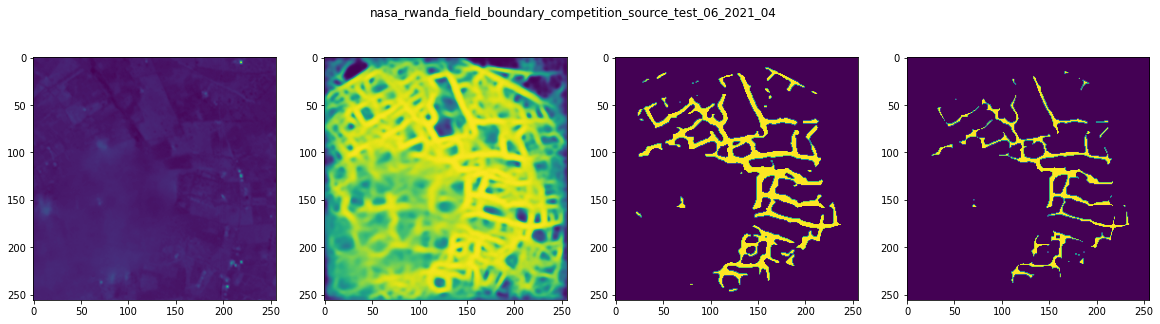

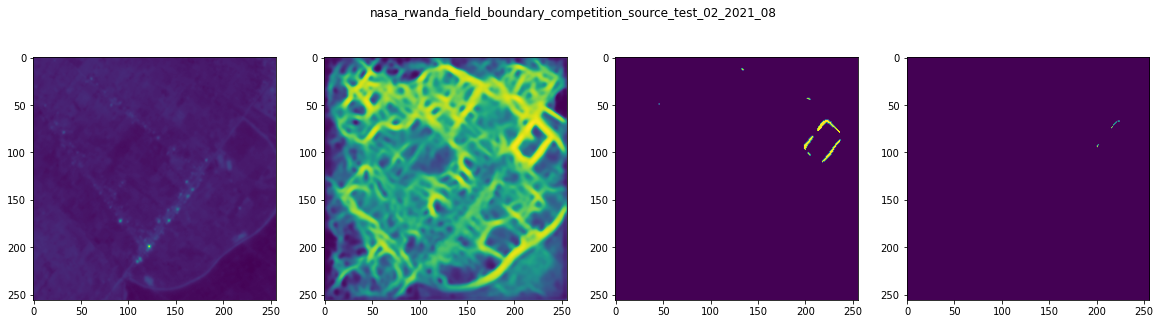

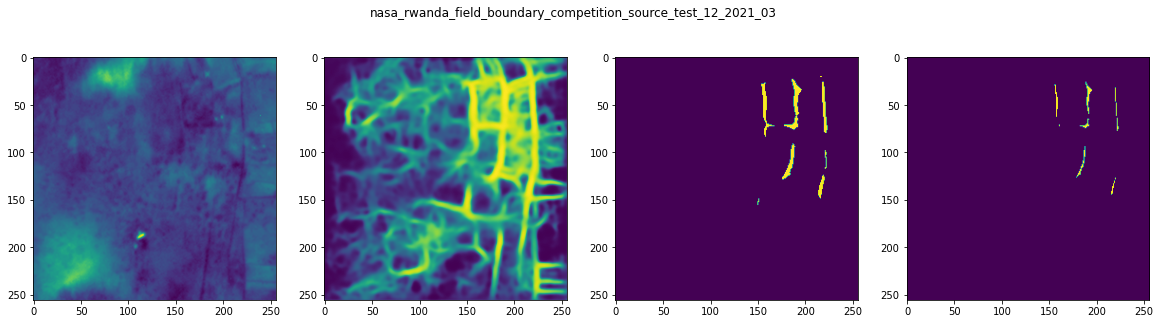

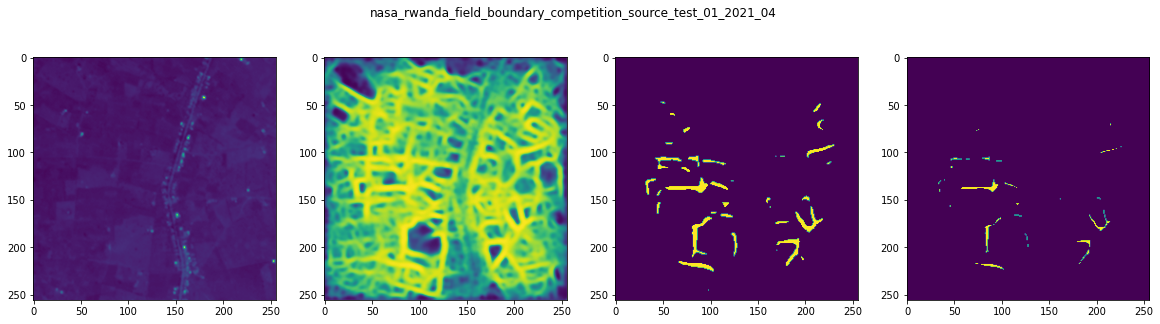

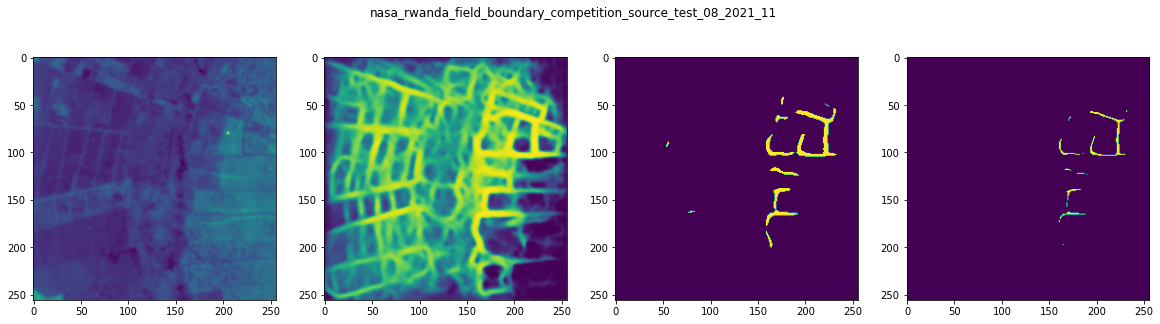

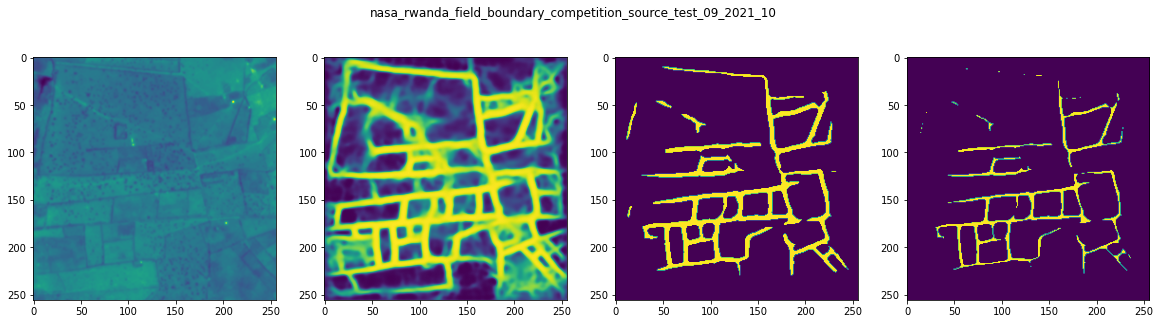

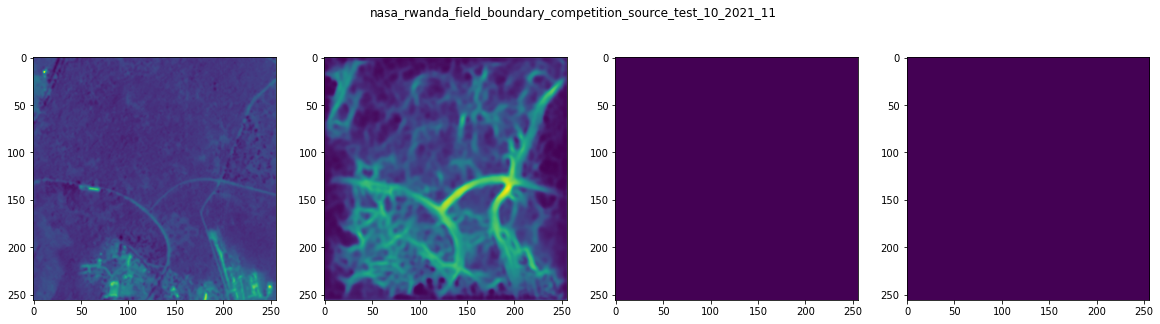

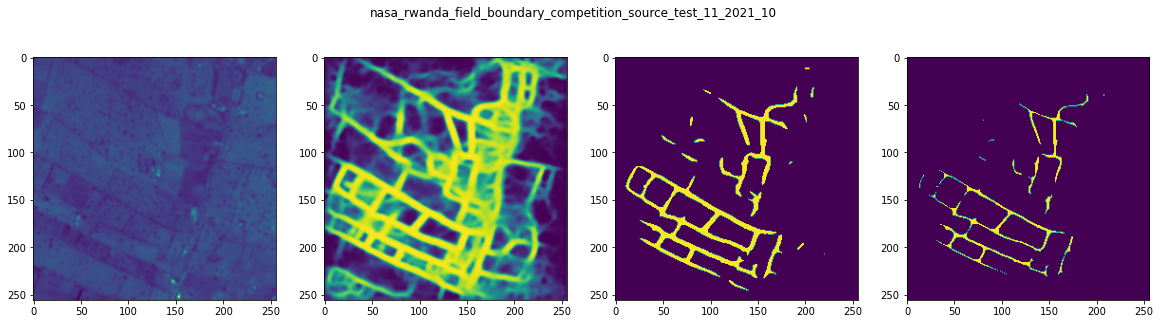

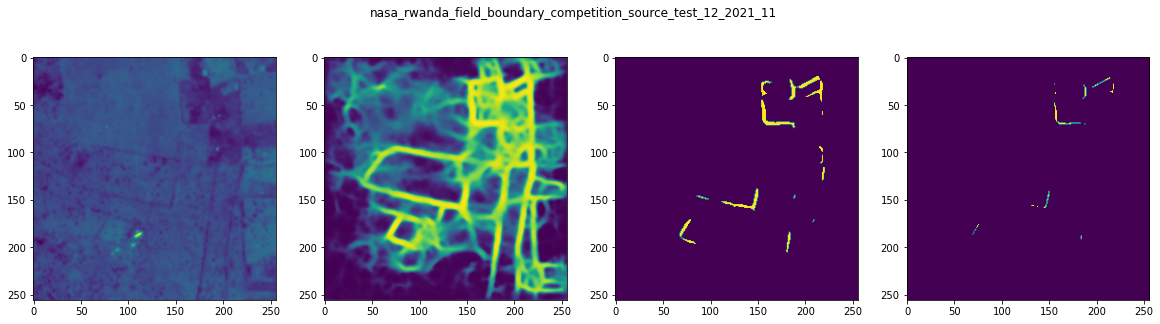

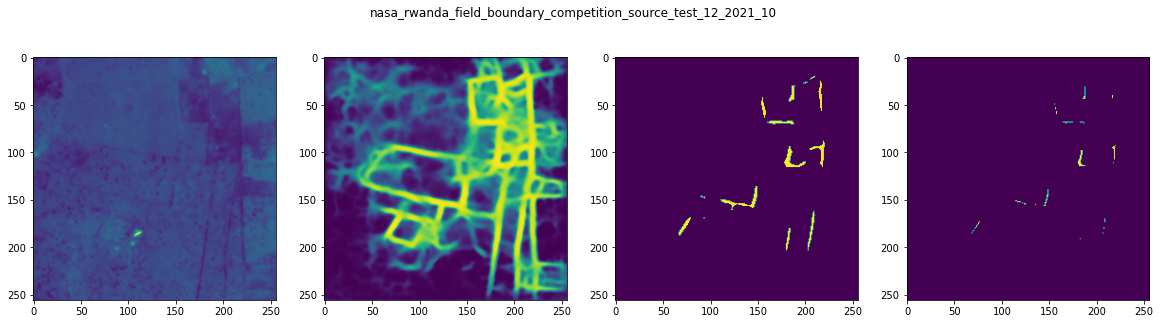

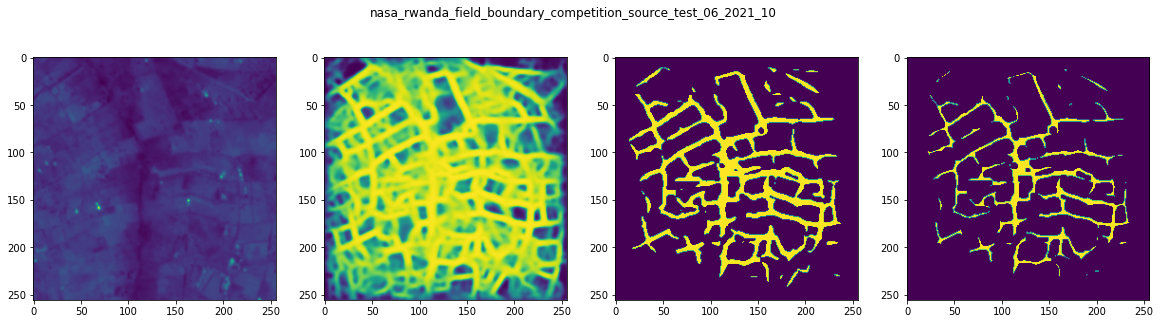

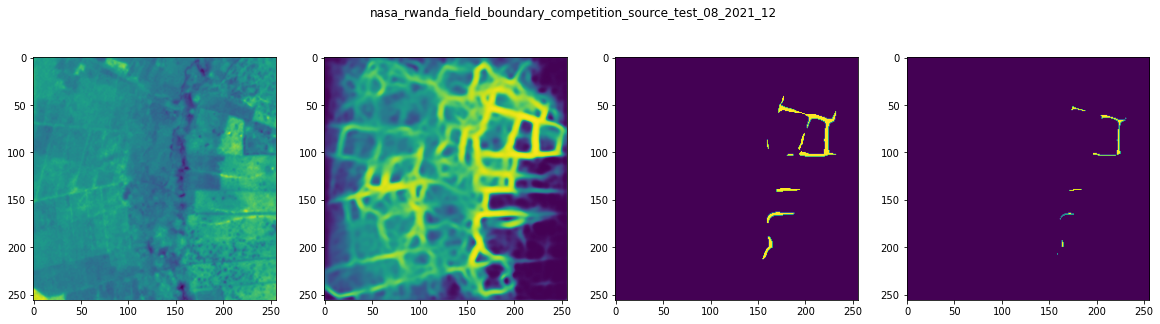

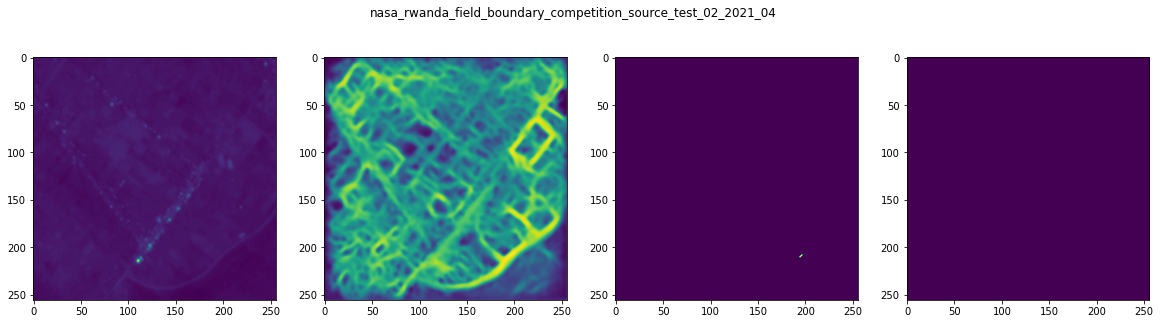

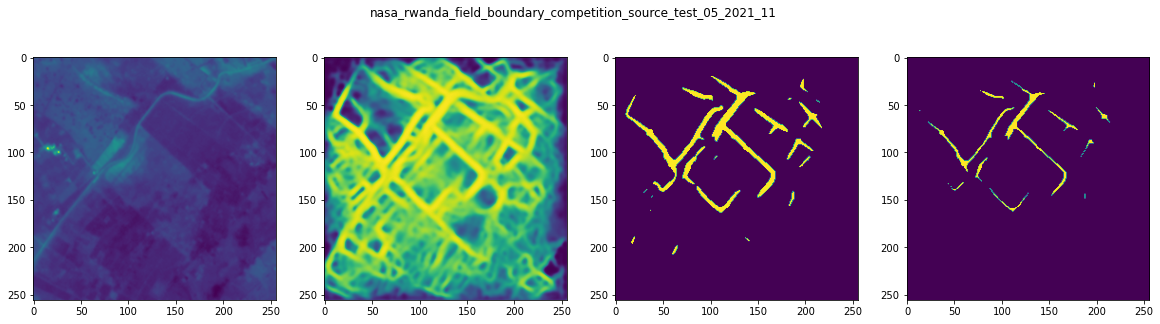

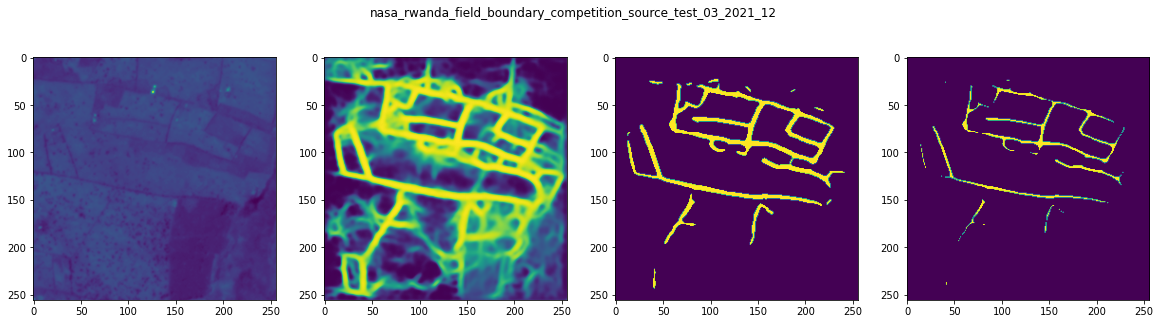

In [ ]:
boundary_best_thresh = .95
for i in range(test_input_img.shape[0]):

  img = test_input_img[i]
  plt.figure(figsize=(20,5))
  plt.suptitle(observation_info[i])
  plt.subplot(141)
  plt.imshow(img.mean(dim=0))
  plt.subplot(142)
  predicted_mask = torch.clone(predicted_scores[i][0].detach().cpu())
  plt.imshow(predicted_mask)
  plt.subplot(143)
  predicted_mask[predicted_mask >= boundary_best_thresh] = 1
  predicted_mask[predicted_mask < boundary_best_thresh] = 0
  plt.imshow(predicted_mask)  

  plt.subplot(144)

  predicted_mask_arr = predicted_scores[i][0].detach().cpu().cpu().numpy()
  # Define the structuring element
  kernel = np.ones((3,3), np.uint8)
  # Erosion
  erosion = cv2.erode(predicted_mask_arr, kernel, iterations=1)
  # Closing
  closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
  plt.imshow(closing > boundary_best_thresh)

# Output Creation

With 300 overall submissions allowed, this meant ample opportunity (& exploration) was necessary to understand how effective the models I trained were. To fully explore this space, that meant better understanding how two factors in particular fed into the results: what prediction strategy was used, and what threshold was optimal. 


For prediction strategy, these are highlighted below. Since there are 6 versions of the test image, this means there are 6 predictions per pixel, so some aggregation was needed to output a score. Given this set, 3 options were selected: mean, median, and maximal aggregation. 

After selecting some confidence from the set of predictions, what's left to do is impose some decision function to say whether or not we think that is a 0 or 1. To handle this, I sampled various thresholds, included as part of the submission file name, and depending on which had the most success, I am able to go back and reproduce that result. 

The code below is mainly meant to dump out this csv file for submission, but as a way to spot-check these results, I have also included some code for reconstructing the predicted boundary lines, which helped me see if the strategies described above were sound.

## Mean-confidence prediction strategy

In [ ]:
threshold = .92
averaged_row_predictions = all_tile_predictions.groupby('tile_row_column')['label'].mean().reset_index()
averaged_row_predictions.loc[averaged_row_predictions['label'] > threshold, 'label'] = 1
averaged_row_predictions.loc[averaged_row_predictions['label'] <= threshold , 'label'] = 0
averaged_row_predictions['label'] = averaged_row_predictions['label'].astype('int')
averaged_row_predictions.to_csv(f'/content/drive/MyDrive/data/submissions/averaged_ensemble_{threshold}.csv',index=False)

averaged_row_predictions['label'].describe()


count    851968.000000
mean          0.056893
std           0.231638
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: label, dtype: float64

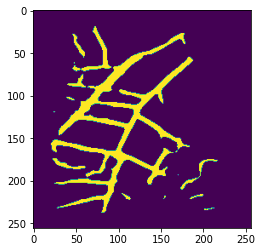

In [ ]:
averaged_row_predictions['tile'] = averaged_row_predictions['tile_row_column'].apply(lambda x: x.split('_')[0])
averaged_row_predictions['row'] = averaged_row_predictions['tile_row_column'].apply(lambda x: x.split('_')[1]).astype(int)
averaged_row_predictions['col'] = averaged_row_predictions['tile_row_column'].apply(lambda x: x.split('_')[2]).astype(int)
tile_df = averaged_row_predictions[averaged_row_predictions['tile'] == 'Tile00']

plt.figure()
plt.imshow(tile_df.sort_values(by=['col','row'])['label'].values.reshape(256,256))



## Max-confidence prediction strategy

In [ ]:
threshold = .95
max_row_predictions = all_tile_predictions.groupby('tile_row_column')['label'].max().reset_index()
max_row_predictions.loc[max_row_predictions['label'] >= threshold , 'label'] = 1
max_row_predictions.loc[max_row_predictions['label'] <= threshold , 'label'] = 0
max_row_predictions['label'] = max_row_predictions['label'].astype('int')
max_row_predictions.to_csv(f'/content/drive/MyDrive/data/submissions/max_ensemble_{threshold}.csv',index=False)

max_row_predictions['label'].describe()


count    851968.000000
mean          0.124561
std           0.330221
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: label, dtype: float64

## Median-confidence prediction strategy

In [ ]:
threshold = .90
median_row_predictions = all_tile_predictions.groupby('tile_row_column')['label'].median().reset_index()
median_row_predictions.loc[median_row_predictions['label'] > threshold, 'label'] = 1
median_row_predictions.loc[median_row_predictions['label'] <= threshold , 'label'] = 0
median_row_predictions['label'] = median_row_predictions['label'].astype('int')
median_row_predictions.to_csv(f'/content/drive/MyDrive/data/submissions/median_ensemble_{threshold}.csv',index=False)

median_row_predictions['label'].describe()


count    851968.000000
mean          0.099572
std           0.299428
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: label, dtype: float64